In [1]:
#-------- Import Libraries --------#

import torch
import time
import os
import gc
import sys
import random
import pickle
import mlflow
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sn
import matplotlib.pyplot as plt
from datetime import date
import collections
from sklearn.metrics import matthews_corrcoef
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

In [2]:
#-------- Import Modules from project--------#
import encoding as enc
from model import Net, Net_thesis, Net_project, Net_project_simple_CNN_RNN
import functions as func

In [3]:
#-------- Set Device --------#

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
else:
    print('No GPUs available. Using CPU instead.')
    device = torch.device('cpu')

No GPUs available. Using CPU instead.


In [4]:
#-------- Seeds --------#

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

torch.use_deterministic_algorithms(True)

In [5]:
#-------- Import Modules from project--------#

import encoding as enc
from model import Net_project
import functions as func


In [6]:
#-------- Import Dataset --------#

#data_list = []
target_list = []

import glob
for i in range(5):
    i = i+1
    print(i)
    for fp in glob.glob("*{}*input.npz".format(i)):
        print(fp)
        #data = np.load(fp)["arr_0"]
        targets = np.load(fp.replace("input", "labels"))["arr_0"]
        #data_list.append(data)
        target_list.append(targets)

data_partitions = len(target_list)

print("\nNumber of files:", data_partitions)

for i in range(len(target_list)):
    print("File:", i)
    frequency = collections.Counter(target_list[i])
    print(dict(frequency), "\n")
    
data_partitions = len(target_list)
for i in range(data_partitions):
    print("Size of file", i+1, len(target_list[i]))

1
P1_input.npz
2
P2_input.npz
3
P3_input.npz
4
P4_input.npz
5
P5_input.npz

Number of files: 5
File: 0
{1.0: 380, 0.0: 1146} 

File: 1
{1.0: 292, 0.0: 876} 

File: 2
{1.0: 370, 0.0: 1110} 

File: 3
{1.0: 383, 0.0: 1149} 

File: 4
{1.0: 301, 0.0: 906} 

Size of file 1 1526
Size of file 2 1168
Size of file 3 1480
Size of file 4 1532
Size of file 5 1207


In [7]:
#-------- Select the network you would like to use -------#

CNN = False # ONLY CNN
CNN_RNN = True # CNN + RNN

# Type of embedding
embedding = "msa"   #"asm"
keep_energy = True

esm_1b_separated = True   ### update
if esm_1b_separated:       ### update
    keep_energy = False

# Hyperparameters to fine-tune
numHN = 32
numFilter = 100
dropOutRate = 0.1
learning_rate = 0.001
weight_decay = 0.0001

# For ml-flow
name_experiment = "hyperparameter_grid"


##--- parameters fixed
cross_validation = False
bat_size = 128
num_classes=1
epochs = 100
patience=10
criterion = nn.BCEWithLogitsLoss()
    

In [8]:
# Parameters
embedding = "msa"
numHN = 64
numFilter = 200
dropOutRate = 0.1
esm_1b_separated = True
learning_rate = 0.0005
weight_decay = 0.0001
name_experiment = "hyperparameter grid"


In [9]:
data_list_enc = list() ### update

In [10]:
#embedding of data

try:
    os.mkdir(embedding_dir)
except:
    pass

#try to fecth if already exist
if embedding == "Baseline":   
    data_list_enc = data_list
    
elif embedding == "esm-1b":
    if esm_1b_separated == False:
        pass
            
    if esm_1b_separated == True:
        for file_index in range(5):
            
            infile = open('esm-energies-file-updated-{}.pkl'.format(file_index+1), 'rb')
            encoding = pickle.load(infile)
            data_list_enc.append(encoding)
            del encoding
            gc.collect()
            infile.close()
            print("ESM File", file_index+1, "is loaded.")
            
else: #msa
    if esm_1b_separated == False:
        pass
            
    if esm_1b_separated == True:
        for file_index in range(5):
            
            infile = open('esm-energies-file-MSA-{}.pkl'.format(file_index+1), 'rb')
            encoding = pickle.load(infile)
            data_list_enc.append(encoding) 
            infile.close()
            print("MSA File", file_index+1, "is loaded.")
    
print("Done")

MSA File 1 is loaded.


MSA File 2 is loaded.


MSA File 3 is loaded.


MSA File 4 is loaded.


MSA File 5 is loaded.
Done


In [11]:
#-------- Print Dimentions -------# ### update

if embedding == "baseline":
    print("baseline")
    print(len(data_list_enc), "\n")

    for i in range(len(data_list)):
        print("number of complexes:", len(data_list[i]))
        print("number of rows:", len(data_list[i][0]))
        print("number of columns:", len(data_list[i][0][0]))
        print("\n")

else:
    print("Total number of files:", len(data_list_enc), "\n")

    for i in range(len(data_list_enc)):
        print("File", i)
        print("number of complexes:", len(data_list_enc[i]))
        print("number of rows:", len(data_list_enc[i][0]))
        print("number of columns:", len(data_list_enc[i][0][0]))
        print("\n")

Total number of files: 5 

File 0
number of complexes: 1526
number of rows: 420
number of columns: 801


File 1
number of complexes: 1168
number of rows: 420
number of columns: 801


File 2
number of complexes: 1480
number of rows: 420
number of columns: 801


File 3
number of complexes: 1532
number of rows: 420
number of columns: 801


File 4
number of complexes: 1207
number of rows: 420
number of columns: 801




In [12]:
print(len(data_list_enc))
print(len(data_list_enc[0]))
print(len(data_list_enc[0][0]))
print(len(data_list_enc[0][0][0]))

5
1526
420
801


In [13]:
#Train
X_train = np.concatenate(data_list_enc[0:3])
y_train = np.concatenate(target_list[0:3])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples, nx, ny)

#Features and Residues
features = list(range(ny))
residues = list(range(nx)) 
n_features = len(features)
input_size = len(residues)

train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i][:,features]), y_train[i]])
del X_train, y_train
gc.collect()
train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
del train_ds
gc.collect()



#Validation
X_valid = np.concatenate(data_list_enc[3:4])
y_valid = np.concatenate(target_list[3:4])
nsamples, nx, ny = X_valid.shape
print("Validation set shape:", nsamples, nx, ny)
len_X_valid = len(X_valid)
val_ds = []
for i in range(len(X_valid)):
    val_ds.append([np.transpose(X_valid[i][:,features]), y_valid[i]])
del X_valid, y_valid
gc.collect()
val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)

del val_ds
gc.collect()



#Test
X_test = np.concatenate(data_list_enc[4:])
y_test = np.concatenate(target_list[4:])
nsamples, nx, ny = X_test.shape
print("Test set shape:", nsamples,nx,ny)

test_ds = []
for i in range(len(X_test)):
    test_ds.append([np.transpose(X_test[i][:,features]), y_test[i]])
test_ldr = torch.utils.data.DataLoader(test_ds,batch_size=len(test_ds), shuffle=True) ## Test at once

del X_test, y_test, test_ds
gc.collect()


Training set shape: 4174 420 801


Validation set shape: 1532 420 801


Test set shape: 1207 420 801


0

In [14]:
###############################
###    CNN+RNN (thesis)     ###
###############################
start = time.time()

if cross_validation == False:
    
    print("Parameters:")
    print("cross_validation", cross_validation)
    print("embedding", embedding)
    print("numHN", numHN)
    print("numFilter", numFilter)
    print("dropOutRate", dropOutRate)
    print("esm_1b_separated", esm_1b_separated) 
    print("keep_energy", keep_energy)
    print("num_classes", num_classes)
    print("learning_rate", learning_rate)
    print("bat_size", bat_size)
    print("patience", patience)
    print("criterion", criterion)
    print("\n\n")
    
    #-------- Train --------#

    # Initialize network
    net = Net_project_simple_CNN_RNN(num_classes=num_classes, 
             n_features=n_features, 
             numHN_lstm=numHN, 
             numFilter=numFilter,
             dropOutRate=dropOutRate).to(device)
    
    optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                           weight_decay=weight_decay,
                           amsgrad=True,)
    
    train_acc, train_losses, train_auc, valid_acc, valid_losses, valid_auc, val_preds, val_targs, test_preds, test_targs, test_loss, test_acc, test_auc = func.train_project(net, optimizer, train_ldr, val_ldr, test_ldr, len_X_valid, epochs, criterion, patience)

else:
    pass

print("Done in", round((time.time()-start)/60,2), "mins." )

print("test_acc, test_auc:")
print(test_acc[0], ",", test_auc[0])


Parameters:
cross_validation False
embedding msa
numHN 64
numFilter 200
dropOutRate 0.1
esm_1b_separated True
keep_energy False
num_classes 1
learning_rate 0.0005
bat_size 128
patience 10
criterion BCEWithLogitsLoss()





Epoch 0  	 Train loss: 0.00439 	 Validation loss: 0.00403


Epoch 5  	 Train loss: 0.00205 	 Validation loss: 0.00306


Epoch 10  	 Train loss: 0.00070 	 Validation loss: 0.00410


Epoch 15  	 Train loss: 0.00036 	 Validation loss: 0.00442


Early stopping



Done in 7.4 mins.
test_acc, test_auc:
0.844241922120961 , 0.7209852368484742


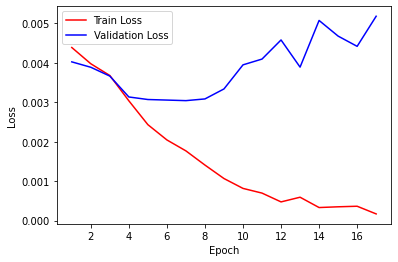

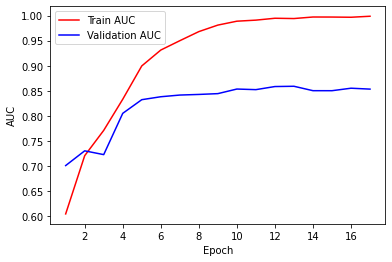

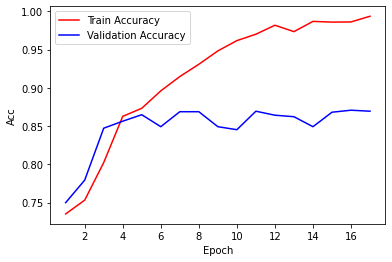

AUC:  0.7209852368484742
MCC:  0.545704182629953


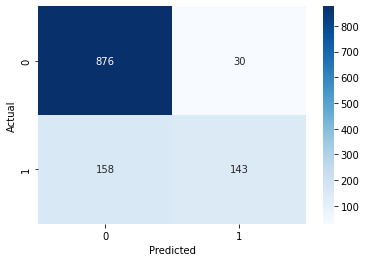

AUC: 0.721
188


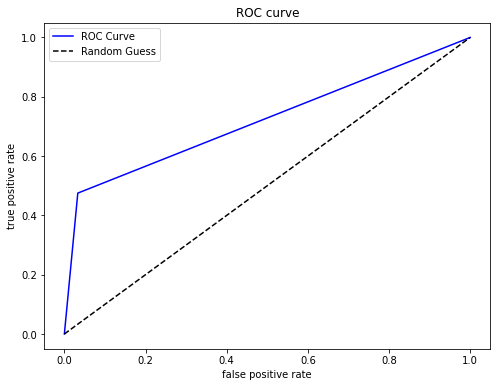

AUC:  0.7209852368484742
MCC:  0.545704182629953
ACC:  0.844241922120961


In [15]:
#-------- Performance --------#

epoch = np.arange(1,len(train_losses)+1)
plt.figure()
plt.plot(epoch, train_losses, 'r', epoch, valid_losses, 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')

epoch = np.arange(1,len(train_auc)+1)
plt.figure()
plt.plot(epoch, train_auc, 'r', epoch, valid_auc, 'b')
plt.legend(['Train AUC','Validation AUC'])
plt.xlabel('Epoch'), plt.ylabel('AUC')

epoch = np.arange(1,len(train_acc)+1)
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.xlabel('Epoch'), plt.ylabel('Acc')
plt.show()


#-------- Save results --------#

results_dir = 'results'

try:
    os.mkdir(results_dir)
except:
    pass

plots_dir = 'results/plots'

try:
    os.mkdir(plots_dir)
except:
    pass

results = pd.DataFrame(list(zip( (int(x) for x in test_targs), (int(x) for x in test_preds))),columns =['target', 'pred'])

#print(results)
results.to_csv('results/targets_vs_preds_emb_{}_HN_{}_nFilt_{}_do_{}_energy_{}_separated_{}.csv'.format(embedding,numHN,numFilter,int(dropOutRate*10), keep_energy, str(esm_1b_separated)), index=False)


#-------- Performance Evaluation --------#
# The results change every time we train, we should check why (maybe we missed something or did wrong with the seeds?)

print("AUC: ", roc_auc_score(results['target'], results['pred']))
print("MCC: ", matthews_corrcoef(results['target'], results['pred']))

confusion_matrix = pd.crosstab(results['target'], results['pred'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

# Plot roc curve

fpr, tpr, thres = roc_curve(results['target'], results['pred'])
print('AUC: {:.3f}'.format(roc_auc_score(results['target'], results['pred'])))

print( len([i for i, (a, b) in enumerate(zip(results['pred'], results['target'])) if a != b]))

plt.figure(figsize=(8,6))

# roc curve
plt.plot(fpr, tpr, "b", label='ROC Curve')
plt.plot([0,1],[0,1], "k--", label='Random Guess')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")

plt.savefig('results/plots/targets_vs_preds_emb_{}_HN_{}_nFilt_{}_do_{}_energy_{}_separated_{}_ROC.png'.format(embedding,numHN,numFilter,int(dropOutRate*10), keep_energy, str(esm_1b_separated)))
plt.show()

AUC = roc_auc_score(results['target'], results['pred'])
MCC = matthews_corrcoef(results['target'], results['pred'])
ACC = accuracy_score(results['target'], results['pred'])
print("AUC: ", AUC)
print("MCC: ", MCC)
print("ACC: ", ACC)

In [16]:
#storing values
import mlflow
import mlflow.sklearn

print(name_experiment)
exp = mlflow.set_experiment(name_experiment)
experiment = mlflow.get_experiment(exp.experiment_id)

print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))

with mlflow.start_run():
    mlflow.log_param('embedding', embedding) 
    
    mlflow.log_param('esm_1b_separated', str(esm_1b_separated)) ### update
    
    mlflow.log_param('Hidden Neurons', numHN)
    mlflow.log_param('filters CNN', numFilter)
    mlflow.log_param('Dropout rate', dropOutRate)
    mlflow.log_param('learning rate', learning_rate)
    mlflow.log_param('Weight decay', weight_decay)
    
    mlflow.log_metric('test AUC', AUC)
    mlflow.log_metric('test MCC', MCC)
    mlflow.log_metric('test ACC', ACC)
    
    mlflow.log_metric('train ACC', train_acc[-1])
    mlflow.log_metric('train AUC', train_auc[-1])
    mlflow.log_metric('valid ACC', valid_acc[-1])
    mlflow.log_metric('valid AUC', valid_auc[-1])


hyperparameter grid
Name: hyperparameter grid
Experiment_id: 1
Artifact Location: file:///home/shannara/DL_02456/workstation/mlruns/1


In [17]:
from csv import writer


print("\n")
print('embedding', embedding) 

print('esm_1b_separated', str(esm_1b_separated)) ### update

print('Hidden Neurons', numHN)
print('filters CNN', numFilter)
print('Dropout rate', dropOutRate)
print('learning rate', learning_rate)
print('Weight decay', weight_decay)

print('test AUC', AUC)
print('test MCC', MCC)
print('test ACC', ACC)

print('train ACC', train_acc[-1])
print('train AUC', train_auc[-1])
print('valid ACC', valid_acc[-1])
print('valid AUC', valid_auc[-1])


#List = ['embedding', 'numHN', 'numFilter', 'dropOutRate', 'learning_rate', 'weight_decay', 'AUC', 'MCC', 'ACC', 'train_acc', 'train_auc', 'valid_acc', 'valid_auc' ]
List = [embedding, numHN, numFilter, dropOutRate, learning_rate, weight_decay, AUC, MCC, ACC, train_acc[-1], train_auc[-1], valid_acc[-1], valid_auc[-1] ]

with open('separated_results.csv', 'a') as f_object:
    writer_object = writer(f_object)
  
    writer_object.writerow(List)
  
    f_object.close()



embedding msa
esm_1b_separated True
Hidden Neurons 64
filters CNN 200
Dropout rate 0.1
learning rate 0.0005
Weight decay 0.0001
test AUC 0.7209852368484742
test MCC 0.545704182629953
test ACC 0.844241922120961
train ACC 0.9935313847628174
train AUC 0.9986992668093337
valid ACC 0.8694516971279374
valid AUC 0.8532768873830576
